### Name: Syed Asad Rizvi
### ERP ID: 25365
### Subject: Machine Learning-II
### Project: Analysis of Distribution-based Clustering Methods

Importing Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score

Creating function to draw elbow curves and dendrograms

In [29]:
# Function to create elbow curves and dendrograms

def elbow_curve_and_dendrogram(dataset, N_cluster, batch_size, dendro_cluster):
    fig = plt.figure(figsize=(20,6))
    
    plt.subplot(1, 2, 1)
    model = MiniBatchKMeans(n_clusters=N_cluster, random_state=0, batch_size=batch_size)
    visualizer = KElbowVisualizer(model, k=(4,12)).fit(dataset)
    global elbow_best_value
    elbow_best_value = visualizer.elbow_value_
    print('For MiniBatchKMeans, the ideal number of clusters are ', elbow_best_value)
    
    plt.subplot(1, 2, 2)
    dendrogram = sch.dendrogram(sch.linkage(dataset, method='complete'))
    print('Based on dendrogram, the ideal number of clusters are ', dendro_cluster)

    plt.tight_layout()

Creating functions to obtain intrinsic and extrinsic measures for all clustering algorithms

In [30]:
# Function for all clustering algorithms other than GMM and Bayesian GMM

def evaluation_matrix(dataset, X, y, elbow_best_value, dendogram_best_number, batch_size, ep_s, min_sample, spectral_clusters, label_assign, damping_value, max_iteration, affinity_type):

    # Output list to append all metric scores
    output_list = []

    # Dictionary of clustering algorithms   
    evaluation_matrix_models = {
        
        'MiniBatchKMeans': [MiniBatchKMeans(n_clusters=elbow_best_value, random_state=0, batch_size=batch_size).fit(dataset),
                            MiniBatchKMeans(n_clusters=elbow_best_value, random_state=0, batch_size=batch_size).fit(X).predict(X)],

        'AgglomerativeClustering': [AgglomerativeClustering(n_clusters=dendogram_best_number).fit(dataset), 
                                    AgglomerativeClustering(n_clusters=dendogram_best_number).fit(X).fit_predict(X)],

        'DBSCAN': [DBSCAN(eps=ep_s, min_samples=min_sample).fit(dataset),
                   DBSCAN(eps=ep_s, min_samples=min_sample).fit(X).fit_predict(X)],

        'OPTICS': [OPTICS().fit(dataset),
                   OPTICS().fit(X).fit_predict(X)],
        
        'Spectral Clustering': [SpectralClustering(n_clusters=spectral_clusters, assign_labels=label_assign, random_state=0).fit(dataset),
                               SpectralClustering(n_clusters=spectral_clusters, assign_labels=label_assign, random_state=0).fit(X).fit_predict(X)],
        
        'Affinity Propagation': [AffinityPropagation(damping=damping_value, max_iter=max_iteration, affinity=affinity_type, random_state=0).fit(dataset),
                                AffinityPropagation(damping=damping_value, max_iter=max_iteration, affinity=affinity_type, random_state=0).fit(X).fit_predict(X)],
    }
    
    # Calculating all the metric scores and appending in the output list
    for each in evaluation_matrix_models.keys():
        output_list.append([
            silhouette_score(dataset, evaluation_matrix_models[each][0].labels_, metric='euclidean'),
            davies_bouldin_score(dataset, evaluation_matrix_models[each][0].labels_),
            fowlkes_mallows_score(y, evaluation_matrix_models[each][1]),
            adjusted_rand_score(y, evaluation_matrix_models[each][1]),
            mutual_info_score(y, evaluation_matrix_models[each][1]),
            v_measure_score(y, evaluation_matrix_models[each][1]),
            homogeneity_score(y, evaluation_matrix_models[each][1]),
            completeness_score(y, evaluation_matrix_models[each][1])])

    # Dataframe of scores for each dataset
    evaluation_matrix_df = pd.DataFrame(output_list, columns=['silhouette_score','davies_bouldin_score','fowlkes_mallows_score',
                                            'adjusted_rand_score','mutual_info_score', 'v_measure_score','homogeneity_score','completeness_score'])
    
    evaluation_matrix_df.set_index([list(evaluation_matrix_models.keys())], drop=True, inplace=True)
    
    return evaluation_matrix_df



# Function for GMM and Bayesian GMM

def bayesian_and_gaussian(dataset, X, y, components, type_covariance, covariance_reg):

    # Output list to append all metric scores
    output_list = []

    # Dictionary of GMM and Bayesian GMM algorithms 
    bayesian_and_gaussian_mixture = {
        
        'Bayesian Gaussian Mixture': [BayesianGaussianMixture(n_components=components, covariance_type=type_covariance, reg_covar=covariance_reg, random_state=0).fit(dataset),
                                     BayesianGaussianMixture(n_components=components, covariance_type=type_covariance, reg_covar=covariance_reg, random_state=0).fit(X).fit_predict(X)],
        
        'Gaussian Mixture': [GaussianMixture(n_components=components, covariance_type=type_covariance, reg_covar=covariance_reg, random_state=0).fit(dataset),
                            GaussianMixture(n_components=components, covariance_type=type_covariance, reg_covar=covariance_reg, random_state=0).fit(X).fit_predict(X)]}

    # Calculating all the metric scores and appending in the output list
    for each in bayesian_and_gaussian_mixture.keys():
        output_list.append([
            fowlkes_mallows_score(y, bayesian_and_gaussian_mixture[each][1]),
            adjusted_rand_score(y, bayesian_and_gaussian_mixture[each][1]),
            mutual_info_score(y, bayesian_and_gaussian_mixture[each][1]),
            v_measure_score(y, bayesian_and_gaussian_mixture[each][1]),
            homogeneity_score(y, bayesian_and_gaussian_mixture[each][1]),
            completeness_score(y, bayesian_and_gaussian_mixture[each][1])])

    # Dataframe of scores for each dataset
    bayesian_gaussian_matrix_df = pd.DataFrame(output_list, columns=['fowlkes_mallows_score','adjusted_rand_score',
                                                              'mutual_info_score', 'v_measure_score',
                                                              'homogeneity_score','completeness_score'])
    
    bayesian_gaussian_matrix_df.set_index([list(bayesian_and_gaussian_mixture.keys())], drop=True, inplace=True)

    return bayesian_gaussian_matrix_df

## Classification Datasets

## Dataset 01: Hepatitis C Virus (HCV) data

This classification data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age. It has 616 rows with 14 columns, and all attributes except Category and Sex are numerical. The target attribute for classification is Category (Blood donors vs. Hepatitis C (including its progress ('just' Hepatitis C, Fibrosis, Cirrhosis)).

In [173]:
# Loading the dataset
df = pd.read_csv('Classification\hcvdat0.csv')
df = df.drop(columns=['Unnamed: 0'])

# Dropping null values
df = df.dropna()

# Converting string columns to integer
for i in df.select_dtypes(include=[object]).columns:
    df[i] = pd.factorize(df[i])[0] + 1
    
# Normalizing the data 
ss=StandardScaler()
for i in df.columns:
    df[i] = ss.fit_transform(df[[i]])
    
# Splitting into X and y columns
X = df.drop(columns = ['Category'])
y = df['Category']

For MiniBatchKMeans, the ideal number of clusters are  5
Based on dendrogram, the ideal number of clusters are  2


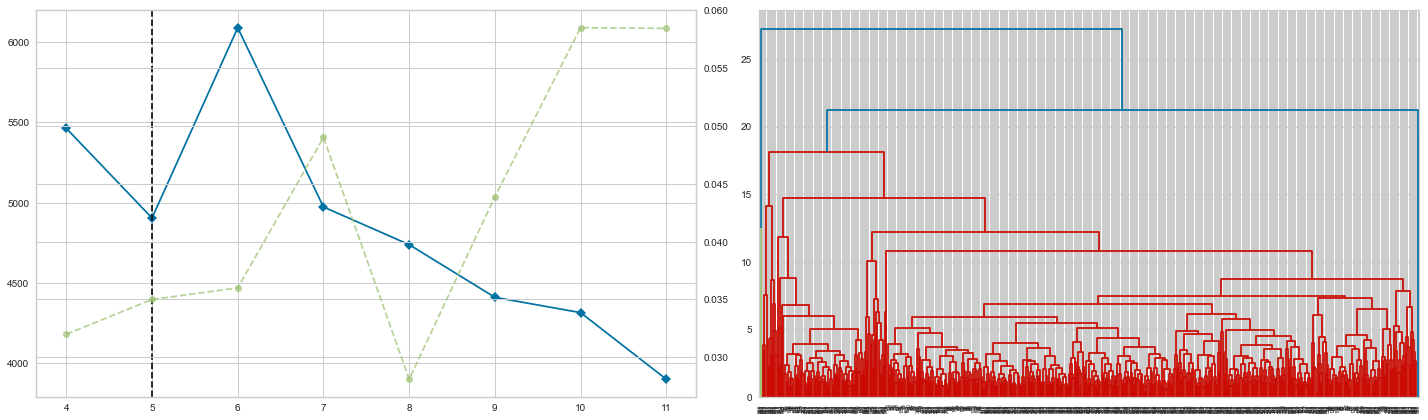

In [32]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df, 5, 50, 2)

In [33]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df, X, y, elbow_best_value, 2, 50, 3, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.157187,1.794483,0.426864,0.006484,0.068558,0.067581,0.143337,0.044214
AgglomerativeClustering,0.622198,1.431741,0.942376,0.666322,0.168248,0.444767,0.351766,0.604618
DBSCAN,0.566512,1.881428,0.944558,0.654745,0.189503,0.524919,0.396205,0.777502
OPTICS,-0.325834,2.099738,0.855640,-0.052094,0.004111,0.012066,0.008596,0.020235
Spectral Clustering,0.763189,0.830189,0.898987,0.076268,0.015411,0.060402,0.032220,0.481999
Affinity Propagation,0.113363,1.096300,0.181590,0.010221,0.354311,0.171491,0.740777,0.096970


In [34]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.920336,0.638894,0.184921,0.417938,0.386624,0.454771
Gaussian Mixture,0.918351,0.631891,0.183185,0.412589,0.382995,0.447140


#### Compare the performances of all clustering algorithms with Gaussian Mixture Model (GMM)

## Hyperparameter Selection

### Mini Batch K-Means

In [143]:
# Checking best combination of hyperparameters

best_combination = [[5,50],[6,100],[7,150],[8,50],[8,100]]

mean_score_list = []

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for [5, 50] combination is 0.7570377203466407
Average of all scores for [6, 100] combination is 1.4028770407496192
Average of all scores for [7, 150] combination is 1.1349651548493778
Average of all scores for [8, 50] combination is 1.1525594332625724
Average of all scores for [8, 100] combination is 1.271495335644029


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 6, batch size = 100 

#### Plotting each combination's performance

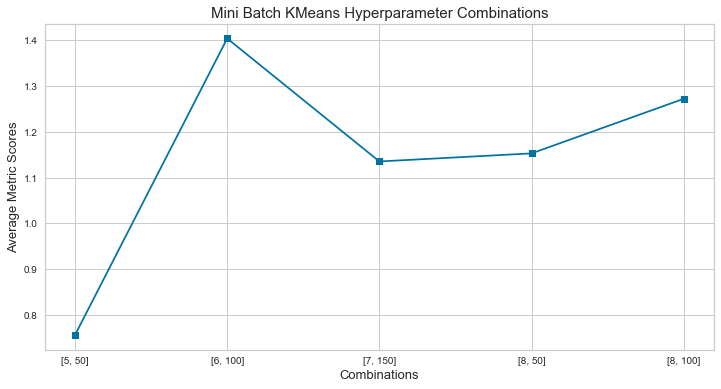

In [168]:
list_of_combinations = [best_combination[0], best_combination[1], best_combination[2], best_combination[3], best_combination[4]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 's', label = [list_of_combinations])
plt.xlabel('Combinations', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('Mini Batch KMeans Hyperparameter Combinations', fontsize=15)
plt.xticks([0,1,2,3,4], list_of_combinations)
plt.show()

### Agglomerative Clustering

In [36]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 3.178097056720994
Average of all scores for 3 clusters is 1.8315290355036078
Average of all scores for 4 clusters is 1.8464532955925406
Average of all scores for 5 clusters is 1.8631582458635079
Average of all scores for 6 clusters is 1.9659647350588791
Average of all scores for 7 clusters is 1.9791138326239521
Average of all scores for 8 clusters is 1.7038560952178832


The best value of number of clusters in Agglomerative Clustering is 2, which gave the highest average metric score.

### DBScan

In [169]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[3,3],[3,5],[5,7]]

mean_score_list = []

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for [0.7, 1] combination is 1.70247328244686
Average of all scores for [1, 2] combination is 0.6154463500115981
Average of all scores for [3, 3] combination is 3.5623557935674537
Average of all scores for [3, 5] combination is 3.4874322094294827
Average of all scores for [5, 7] combination is 2.33979689389448


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 3, minimum number of samples = 3

#### Plotting each combination's performance

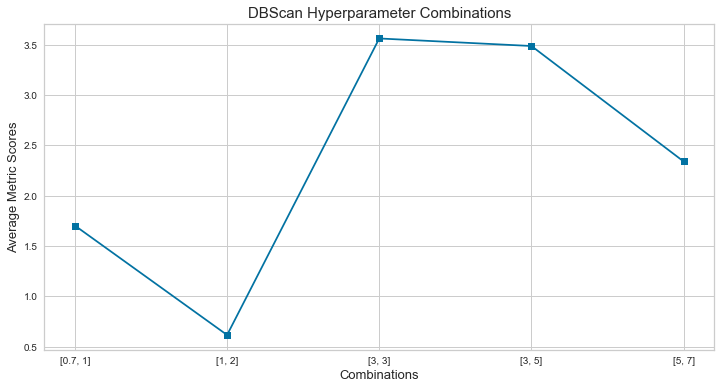

In [170]:
list_of_combinations = [best_combination[0], best_combination[1], best_combination[2], best_combination[3], best_combination[4]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 's', label = [list_of_combinations])
plt.xlabel('Combinations', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('DBScan Hyperparameter Combinations', fontsize=15)
plt.xticks([0,1,2,3,4], list_of_combinations)
plt.show()

### OPTICS

In [38]:
# Checking best value of minimum number of samples

best_combination = [3,4,5,6,7,8]

for i in best_combination:
    model = OPTICS(min_samples=i)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 3 samples is 1.3652494355510825
Average of all scores for 4 samples is 0.7959709803457005
Average of all scores for 5 samples is 0.8485542098265904
Average of all scores for 6 samples is 0.8550665447186081
Average of all scores for 7 samples is 3.3986574400136176
Average of all scores for 8 samples is 0.7680756122206359


The best value of minimum number of samples in OPTICS is 7, which gave the highest average metric score.

### Affinity Propagation

In [39]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 1.8947344642409418
Average of all scores for [0.6, 300] combination is 1.8947344642409418
Average of all scores for [0.7, 400] combination is 1.8947344642409418
Average of all scores for [0.8, 200] combination is 1.5553600651213377
Average of all scores for [0.9, 500] combination is 1.5471455120592839


The best combinations of hyperparameters in Affinity Propagation were three, all gave the highest average metric scores:

damping value, maximum iterations = (0.5,200), (0.6,300), (0.7,400). We can choose any of these to obtain highest scores.

### Spectral Clustering

In [40]:
# Checking best combination of hyperparameters

best_combination = [[5,'discretize'],[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 'discretize'] combination is 2.388460878868222
Average of all scores for [6, 'discretize'] combination is 3.2555122353490575
Average of all scores for [7, 'kmeans'] combination is 1.6018021376332798
Average of all scores for [8, 'kmeans'] combination is 1.7269489468530637
Average of all scores for [9, 'discretize'] combination is 2.060732097882145


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 6, assign labels = 'discretize'

### Bayesian Gaussian Mixture 

In [41]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 3.003483893936974
Average of all scores for [3, 'tied'] combination is 1.2009039028247954
Average of all scores for [4, 'diag'] combination is 1.9397627582414319
Average of all scores for [5, 'spherical'] combination is 1.7177832647855154
Average of all scores for [6, 'full'] combination is 1.9407826165654685
Average of all scores for [7, 'spherical'] combination is 1.3865046987228242
Average of all scores for [8, 'diag'] combination is 1.9747360189334562


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 2, covariance type = 'full'

### Gaussian Mixture Model

In [174]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

mean_score_list = []

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for [2, 'full'] combination is 2.976150751028736
Average of all scores for [3, 'tied'] combination is 1.2086864942360236
Average of all scores for [4, 'diag'] combination is 1.908347716351867
Average of all scores for [5, 'spherical'] combination is 1.6914773808778902
Average of all scores for [6, 'full'] combination is 1.9176788602474146
Average of all scores for [7, 'spherical'] combination is 1.4675540993837985
Average of all scores for [8, 'diag'] combination is 1.9528400456383517


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 2, covariance type = 'full'

#### Plotting each combination's performance

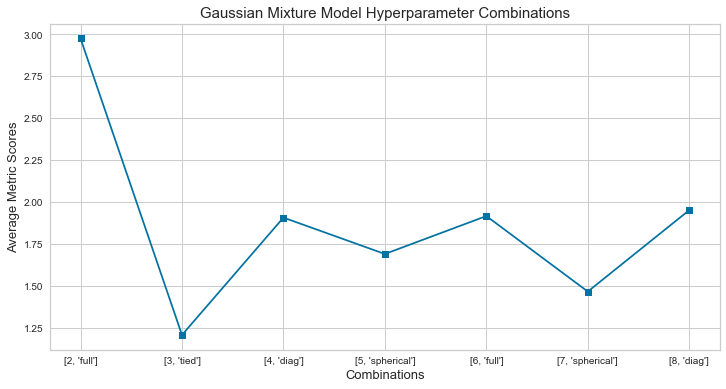

In [175]:
list_of_combinations = [best_combination[0], best_combination[1], best_combination[2], best_combination[3], best_combination[4],
                       best_combination[5], best_combination[6]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 's', label = [list_of_combinations])
plt.xlabel('Combinations', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('Gaussian Mixture Model Hyperparameter Combinations', fontsize=15)
plt.xticks([0,1,2,3,4,5,6], list_of_combinations)
plt.show()

#### Analysis:

1) It is observed that the GMM outperforms Mini Batch KMeans with highest average score, which shows that the GMM is better at modeling the data according to the chosen performance metrics. This could be because the GMM is more flexible and able to capture more complex patterns in the data.

2) It is observed that the Agglomerative Clustering outperforms GMM with highest average score, which shows that the Agglomerative clustering algorithm is better at grouping the data into clusters based on the chosen performance metrics. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

3) It is observed that the DBScan outperforms GMM with highest average score, which shows that DBScan is more accurately identifying clusters or has a lower error rate. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

4) It is observed that the OPTICS outperforms GMM with highest average score, which shows that OPTICS is more effective at clustering the data and finding meaningful patterns within it. This could be due to the fact that OPTICS is able to handle more complex and non-linear data structures, whereas GMM are limited to more simple, linear patterns.

5) It is observed that the GMM outperforms Affinity Propagation with highest average score, which shows that the GMM is a better fit for the data and is able to more accurately predict or classify the data. This could be due to the GMM's ability to model data using a continuous distribution, as opposed to the discrete clustering method used by Affinity propagation.

6) It is observed that the Spectral Clustering outperforms GMM with highest average score, which shows that Spectral Clustering is better at identifying and separating distinct groups within the data set. This could be due to the fact that Spectral Clustering utilizes the graph structure of the data, which may be more effective at identifying and separating non-linearly distributed groups within the data.

7) It is observed that the Bayesian GMM outperforms GMM with slightly higher average score (very close), which shows that both models are performing similarly in terms of their ability to accurately predict or classify data. This may indicate that either model could be a suitable choice for the particular task at hand.

#### Experiment with different values of all possible hyperparameters of GMM

### Parameter tuning:

#### (1) Based on number of components

In [43]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))

Average of all scores for 2 components is 2.976150751028736
Average of all scores for 3 components is 2.06084970676829
Average of all scores for 4 components is 2.0195255215971533
Average of all scores for 5 components is 2.1178825914277826
Average of all scores for 6 components is 1.9176788602474146
Average of all scores for 7 components is 2.089752951844639


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 2. This shows that the model is able to accurately classify the data using fewer components or clusters. This may indicate that the  model is able to effectively capture the underlying structure of the data using fewer components.

#### (2) Based on covariance type 

In [44]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))

Average of all scores for full covariance type is 2.976150751028736
Average of all scores for tied covariance type is 0.6559449582766487
Average of all scores for diag covariance type is 2.9399206609564206
Average of all scores for spherical covariance type is 3.1804482912224903


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is 'full'. This suggests that 'full' covariance parameter allows the model to fit more complex and flexible distributions, allowing it to better represent the data. This can result in improved accuracy and predictive performance for the model.

#### (3) Based on regularization of covariance

In [45]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-6, 0.5, 1.5, 3, 5]

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)    
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))

Average of all scores for regularized covariance of 1e-06 is 2.976150751028736
Average of all scores for regularized covariance of 0.5 is 3.1991761292726215
Average of all scores for regularized covariance of 1.5 is 2.6865059859544878
Average of all scores for regularized covariance of 3 is 2.361698115308954
Average of all scores for regularized covariance of 5 is 1.949852562496532


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 0.5. This suggests that the model is able to accurately classify the data points into different mixture components with a relatively low level of regularization applied to the covariance matrices of the mixture components. This indicates that the data points are well-separated and distinct.

## Dataset 02: Non-verbal tourist data

This dataset contains the information about non-verbal preferences of tourists. A total of 73 customers, aged between 24 and 81 years old, were surveyed. Of the customers surveyed, 38 were returning customers, and 35 were new customers. The variables chosen are the essential ones that make up the non-verbal communication system. The 22 variables analyzed were considered feasible to evaluate by the hotel's clientele.

In [46]:
# Loading the dataset
df2 = pd.read_csv('Classification/non-verbal tourist data.csv')
df2.head()

,sex,age,country,returning,GImg1,GImg2,GImg3,PImg1,PImg2,PImg3,...,Authoritative -anarchic,Hostile - friendly,TAudio1,TAudio2,TAudio3,QAudio1,QAudio2,QAudio3,Proxemics,Type of Client
0,F,42,uruguay,no,likes,indiferent,indiferent,likes,likes,indiferent,...,8,3,C,dislikes,dislikes,indiferent,dislikes,dislikes,dislikes,0
1,M,60,brasil,no,likes,indiferent,indiferent,likes,likes,likes,...,9,1,B,dislikes,dislikes,likes,likes,dislikes,dislikes,0
2,F,25,england,no,indiferent,indiferent,indiferent,likes,likes,indiferent,...,10,5,C,dislikes,dislikes,likes,dislikes,dislikes,dislikes,0
3,M,43,canada,no,likes,dislikes,dislikes,likes,likes,indiferent,...,2,1,C,dislikes,dislikes,likes,dislikes,indiferent,dislikes,0
4,M,30,hungary,no,indiferent,indiferent,indiferent,likes,likes,indiferent,...,9,3,C,dislikes,dislikes,likes,indiferent,dislikes,dislikes,0


In [47]:
# Data shape

df2.shape

(73, 23)

In [48]:
# Converting string columns to integer
for i in df2.select_dtypes(include=[object]).columns:
    df2[i] = pd.factorize(df2[i])[0] + 1
    
# Normalizing the data
ss=StandardScaler()
for i in df2.columns:
    df2[i] = ss.fit_transform(df2[[i]])

# Splitting into X and y columns
X = df2.drop(columns = ['Type of Client'])
y = df2['Type of Client']

For MiniBatchKMeans, the ideal number of clusters are  4
Based on dendrogram, the ideal number of clusters are  2


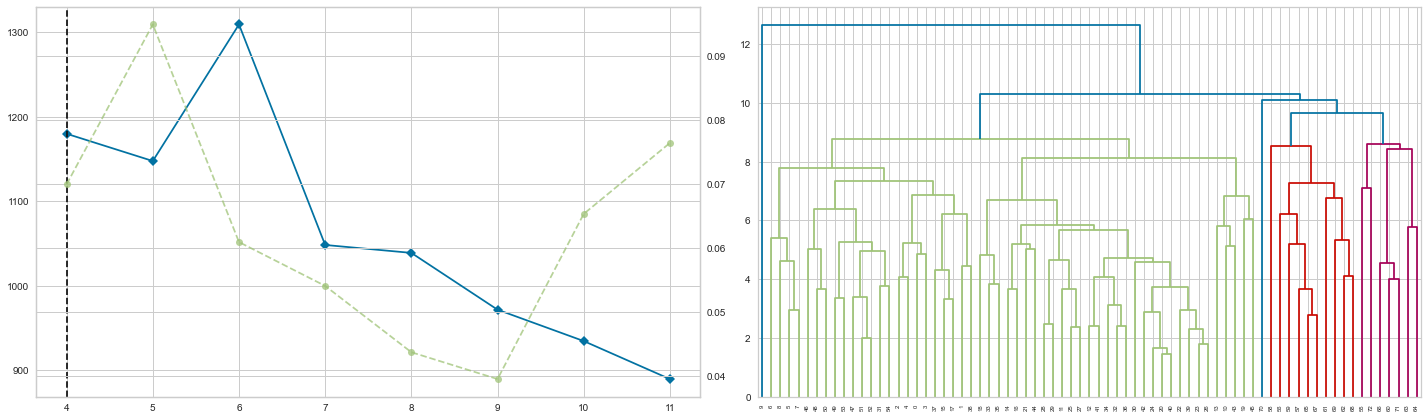

In [49]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df2, 4, 5, 2)

In [50]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df2, X, y, elbow_best_value, 2, 5, 3, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.090005,1.736826,0.678046,0.507181,0.606929,0.482337,0.421612,0.563497
AgglomerativeClustering,0.208051,2.047385,0.592279,0.320891,0.425576,0.399256,0.295633,0.614726
DBSCAN,-0.073917,2.474621,0.420797,-0.089552,0.108081,0.117543,0.075080,0.270570
OPTICS,-0.073917,2.474621,0.420797,-0.089552,0.108081,0.117543,0.075080,0.270570
Spectral Clustering,0.213748,1.956538,0.637783,0.291085,0.372162,0.385992,0.258528,0.761386
Affinity Propagation,0.080199,1.691175,0.378382,0.208150,0.887941,0.486395,0.616821,0.401498


In [51]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df2, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.703147,0.484741,0.457329,0.432105,0.317691,0.675318
Gaussian Mixture,0.698528,0.474877,0.449251,0.425542,0.312079,0.668642


## Hyperparameter Selection

### Mini Batch KMeans

In [52]:
# Checking best combination of hyperparameters

best_combination = [[4,5],[5,5],[6,20],[7,10],[8,10]]

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [4, 5] combination is 3.2596028383887177
Average of all scores for [5, 5] combination is 2.9483477478799625
Average of all scores for [6, 20] combination is 2.8081245645044337
Average of all scores for [7, 10] combination is 2.9248799891394888
Average of all scores for [8, 10] combination is 3.762940996303171


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 8, batch size = 10

### Agglomerative Clustering

In [53]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i) 
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 2.648359894877321
Average of all scores for 3 clusters is 3.951489754388782
Average of all scores for 4 clusters is 3.8540856497146923
Average of all scores for 5 clusters is 3.704602489667917
Average of all scores for 6 clusters is 3.85029080895204
Average of all scores for 7 clusters is 3.753166620715296
Average of all scores for 8 clusters is 3.730960230462271


The best value of number of clusters in Agglomerative Clustering is 3, which gave the highest average metric score.

### DBScan

In [54]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[3,3],[3,5],[5,7]]

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.7, 1] combination is 3.2775233696087516
Average of all scores for [1, 2] combination is 1.5475835945300753
Average of all scores for [3, 3] combination is 1.2412906909313164
Average of all scores for [3, 5] combination is 0.9025184726493213
Average of all scores for [5, 7] combination is 1.1161774188697344


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 0.7, minimum number of samples = 1 

### OPTICS

In [55]:
# Checking best value of minimum number of samples

best_combination = [3,4,5,6,7,8]

for i in best_combination:
    model = OPTICS(min_samples=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 3 samples is 1.1320767210601717
Average of all scores for 4 samples is 1.3155555220243795
Average of all scores for 5 samples is 0.9025184726493213
Average of all scores for 6 samples is 0.9025184726493213
Average of all scores for 7 samples is 0.9025184726493213
Average of all scores for 8 samples is 1.5475835945300753


The best value of minimum number of samples in OPTICS is 8, which gave the highest average metric score.

### Affinity Propagation 

In [56]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 3.350966326890353
Average of all scores for [0.6, 300] combination is 3.011810133671791
Average of all scores for [0.7, 400] combination is 2.979187191590451
Average of all scores for [0.8, 200] combination is 2.979187191590451
Average of all scores for [0.9, 500] combination is 2.122383197242067


The best combinations of hyperparameters in Affinity Propagation which gave the highest average metric scores include:

damping value = 0.5, maximum iterations = 200

### Spectral Clustering 

In [57]:
# Checking best combination of hyperparameters

best_combination = [[5,'discretize'],[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 'discretize'] combination is 3.1910954454461242
Average of all scores for [6, 'discretize'] combination is 3.0472665925449083
Average of all scores for [7, 'kmeans'] combination is 2.962535791140037
Average of all scores for [8, 'kmeans'] combination is 3.5528396439621805
Average of all scores for [9, 'discretize'] combination is 2.986232599659427


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 8, assign labels = 'kmeans'

### Bayesian Gaussian Mixture

In [58]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 3.070331981453408
Average of all scores for [3, 'tied'] combination is 2.8793193041650698
Average of all scores for [4, 'diag'] combination is 2.8999288029148236
Average of all scores for [5, 'spherical'] combination is 1.5475835945300753
Average of all scores for [6, 'full'] combination is 2.8269993654095367
Average of all scores for [7, 'spherical'] combination is 1.5475835945300753
Average of all scores for [8, 'diag'] combination is 2.8220502080902015


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 2, covariance type = 'full'

### Gaussian Mixture Model

In [59]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 3.0289175463547053
Average of all scores for [3, 'tied'] combination is 2.8793193041650698
Average of all scores for [4, 'diag'] combination is 2.095483706516382
Average of all scores for [5, 'spherical'] combination is 2.898261223193028
Average of all scores for [6, 'full'] combination is 2.8269993654095367
Average of all scores for [7, 'spherical'] combination is 3.207891187487359
Average of all scores for [8, 'diag'] combination is 2.9073296302125184


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 7, covariance type = 'spherical'

#### Analysis:

1) It is observed that the Mini Batch KMeans outperforms GMM with highest average score, which shows that the Mini batch kmeans algorithm is better at accurately clustering and identifying patterns in the data. This could be due to the inherent structure of the data, the number of clusters, or the parameters used in the algorithms.

2) It is observed that the Agglomerative Clustering outperforms GMM with highest average score, which shows that the Agglomerative clustering algorithm is better at grouping the data into clusters based on the chosen performance metrics. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

3) It is observed that the DBScan outperforms GMM with highest average score, which shows that DBScan is more accurately identifying clusters or has a lower error rate. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

4) It is observed that the GMM outperforms OPTICS with highest average score, which shows that GMM is more effective at accurately clustering the data. This could be due to the GMM's ability to handle multimodal data and its flexibility in modeling the underlying distribution of the data.

5) It is observed that the Affinity Propagation outperforms GMM with highest average score, which shows that Affinity propagation is a better model for the data at hand. This could be because Affinity propagation is able to more accurately cluster the data, or because it is able to more accurately predict the labels of the data points.

6) It is observed that the Spectral Clustering outperforms GMM with highest average score, which shows that Spectral Clustering is better at identifying and separating distinct groups within the data set. This could be due to the fact that Spectral Clustering utilizes the graph structure of the data, which may be more effective at identifying and separating non-linearly distributed groups within the data.

7) It is observed that the GMM outperforms Bayesian GMM with slightly higher average score (very close), which shows that both models are performing similarly in terms of their ability to accurately predict or classify data. This may indicate that either model could be a suitable choice for the particular task at hand.

#### Experiment with all possible values of hyperparameters of GMM

### Parameter changes:

#### (1) Based on number of components

In [60]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))

Average of all scores for 2 components is 3.0289175463547053
Average of all scores for 3 components is 2.872012785710358
Average of all scores for 4 components is 2.859181317263984
Average of all scores for 5 components is 2.9419720192131296
Average of all scores for 6 components is 2.8269993654095367
Average of all scores for 7 components is 2.919805382334197


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 2. This shows that the model is able to accurately classify the data using fewer components or clusters. This may indicate that the  model is able to effectively capture the underlying structure of the data using fewer components.

#### (2) Based on covariance type

In [61]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))

Average of all scores for full covariance type is 3.0289175463547053
Average of all scores for tied covariance type is 2.610696289554194
Average of all scores for diag covariance type is 3.348440884461584
Average of all scores for spherical covariance type is 2.5968174855305204


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is 'diag'. This suggests that the data may be more effectively modeled with a diagonal covariance matrix rather than a full or spherical covariance matrix. This may indicate that the data has some degree of independence between the different features, as the diagonal covariance matrix assumes that the features are uncorrelated.

#### (3) Based on regularization of covariance

In [62]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-20, 1e-10, 1e-6, 0.5, 1.5, 3]

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))

Average of all scores for regularized covariance of 1e-20 is 2.764338156303532
Average of all scores for regularized covariance of 1e-10 is 3.0185027540755294
Average of all scores for regularized covariance of 1e-06 is 3.0289175463547053
Average of all scores for regularized covariance of 0.5 is 3.2957326208696425
Average of all scores for regularized covariance of 1.5 is 3.0586729117615006
Average of all scores for regularized covariance of 3 is 1.350679019148814


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 0.5. This suggests that the model is able to accurately classify the data points into different mixture components with a relatively low level of regularization applied to the covariance matrices of the mixture components. This indicates that the data points are well-separated and distinct.

## Dataset 03: South German Credit data

The dataset contains 700 good and 300 bad credits with 20 predictor variables. Data is from 1973 to 1975, and consists of 1000 rows and 21 columns. Stratified sample from actual credits with bad credits heavily oversampled.

In [138]:
# Assigning column names

colnames = ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 
            'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age',
           'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker',
           'credit_risk']

# Loading the dataset
df3 = pd.read_csv('Classification\SouthGermanCredit.asc', sep = ' ', names = colnames, header=0)
df3.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [140]:
# Data shape

df3.shape

(1000, 21)

In [141]:
# Normalizing the data

ss=StandardScaler()
for i in df3.columns:
    df3[i] = ss.fit_transform(df3[[i]])

# Splitting into X and y columns

X = df3.drop(columns = ['credit_risk'])
y = df3['credit_risk']

For MiniBatchKMeans, the ideal number of clusters are  9
Based on dendrogram, the ideal number of clusters are  2


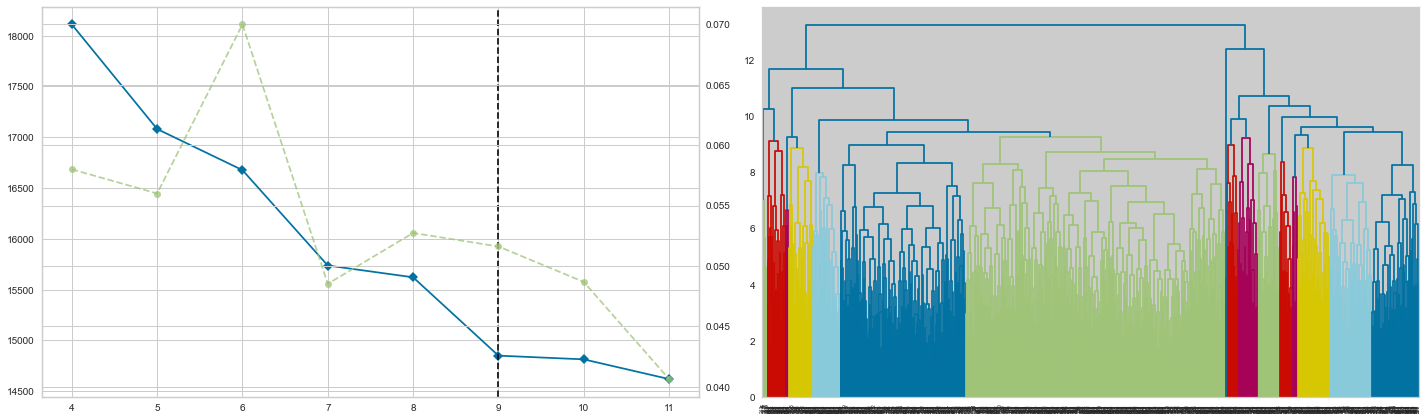

In [66]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df3, 9, 100, 2)

In [67]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df3, X, y, elbow_best_value, 2, 100, 3, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.068894,2.437239,0.303886,0.023484,0.046831,0.034800,0.076663,0.022509
AgglomerativeClustering,0.120193,2.901299,0.726777,-0.025874,0.005206,0.013594,0.008522,0.033581
DBSCAN,-0.087027,2.683341,0.524528,-0.002717,0.008218,0.011506,0.013454,0.010051
OPTICS,-0.185491,1.647590,0.680861,-0.043675,0.016786,0.031035,0.027480,0.035648
Spectral Clustering,0.392785,0.467508,0.726777,-0.025874,0.005206,0.013594,0.008522,0.033581
Affinity Propagation,0.066752,1.950889,0.100665,0.003185,0.124377,0.050575,0.203608,0.028873


In [68]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df3, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.671629,-0.015144,0.00076,0.001557,0.001243,0.002081
Gaussian Mixture,0.671629,-0.015144,0.00076,0.001557,0.001243,0.002081


## Hyperparameter Selection

### Mini Batch KMeans

In [69]:
# Checking best combination of hyperparameters

best_combination = [[5,100],[6,100],[7,200],[8,250],[9,300]]

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 100] combination is 0.664571030890035
Average of all scores for [6, 100] combination is 0.591726654657404
Average of all scores for [7, 200] combination is 0.5199817477884523
Average of all scores for [8, 250] combination is 0.45882365854094853
Average of all scores for [9, 300] combination is 0.4346723793671672


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 5, batch size = 100

### Agglomerative Clustering

In [70]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i) 
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 0.7618050249582294
Average of all scores for 3 clusters is 0.560464544105904
Average of all scores for 4 clusters is 0.55934142243971
Average of all scores for 5 clusters is 0.5262449386480097
Average of all scores for 6 clusters is 0.5118376675997378
Average of all scores for 7 clusters is 0.4634261007058802
Average of all scores for 8 clusters is 0.47320540349017365


The best value of number of clusters in Agglomerative Clustering is 2, which gave the highest average metric score.

### DBScan

In [71]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[3,3],[3,5],[5,7]]

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.7, 1] combination is 1.865160738545676
Average of all scores for [1, 2] combination is 0.8666538102882381
Average of all scores for [3, 3] combination is 0.5944709238606418
Average of all scores for [3, 5] combination is 0.5650399630091982
Average of all scores for [5, 7] combination is 0.7497800193160635


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 0.7, minimum number of samples = 1 

### OPTICS

In [72]:
# Checking best value of minimum number of samples

best_combination = [3,4,5,6,7,8]

for i in best_combination:
    model = OPTICS(min_samples=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 3 samples is 0.7798554081577151
Average of all scores for 4 samples is 0.7553325518488267
Average of all scores for 5 samples is 0.7481347864351919
Average of all scores for 6 samples is 0.7451284650661415
Average of all scores for 7 samples is 0.7335680499439678
Average of all scores for 8 samples is 1.7613012410206486


The best value of minimum number of samples in OPTICS is 8, which gave the highest average metric score.

### Affinity Propagation 

In [73]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 0.5146737654048393
Average of all scores for [0.6, 300] combination is 0.5213436972581578
Average of all scores for [0.7, 400] combination is 0.5112818087596246
Average of all scores for [0.8, 200] combination is 0.5112818087596246
Average of all scores for [0.9, 500] combination is 0.5112818087596246


The best combination of hyperparameters in Affinity Propagation which gave the highest average metric scores:

damping value = 0.6, maximum iterations = 300

### Spectral Clustering 

In [74]:
# Checking best combination of hyperparameters

best_combination = [[5,'discretize'],[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 'discretize'] combination is 0.7706479943502315
Average of all scores for [6, 'discretize'] combination is 0.6562281865178503
Average of all scores for [7, 'kmeans'] combination is 0.7599179609969097
Average of all scores for [8, 'kmeans'] combination is 0.7643608521505479
Average of all scores for [9, 'discretize'] combination is 0.651477579964093


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 5, assign labels = 'discretize'

### Bayesian Gaussian Mixture

In [75]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.662126643666407
Average of all scores for [3, 'tied'] combination is 0.6542594764890124
Average of all scores for [4, 'diag'] combination is 0.5134725226042457
Average of all scores for [5, 'spherical'] combination is 0.741398526616261
Average of all scores for [6, 'full'] combination is 0.6041928002434961
Average of all scores for [7, 'spherical'] combination is 0.7426852237147413
Average of all scores for [8, 'diag'] combination is 0.5196740348983218


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 7, covariance type = 'spherical'

### Gaussian Mixture Model

In [76]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.662126643666407
Average of all scores for [3, 'tied'] combination is 0.63568856968833
Average of all scores for [4, 'diag'] combination is 0.5127333391342886
Average of all scores for [5, 'spherical'] combination is 0.6646795066512212
Average of all scores for [6, 'full'] combination is 0.6200520044633345
Average of all scores for [7, 'spherical'] combination is 0.5871175190860929
Average of all scores for [8, 'diag'] combination is 0.6639676484010228


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 5, covariance type = 'spherical'

#### Analysis:

1) It is observed that the GMM slightly outperforms (and very close to) Mini Batch KMeans with highest average score, which could indicate that both models are performing similarly well in terms of their ability to accurately classify or cluster the data.

2) It is observed that the Agglomerative Clustering outperforms GMM with highest average score, which shows that the Agglomerative clustering algorithm is better at grouping the data into clusters based on the chosen performance metrics. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

3) It is observed that the DBScan outperforms GMM with highest average score, which shows that DBScan is more accurately identifying clusters or has a lower error rate. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

4) It is observed that the OPTICS outperforms GMM with highest average score, which shows that OPTICS is more effective at clustering the data and finding meaningful patterns within it. This could be due to the fact that OPTICS is able to handle more complex and non-linear data structures, whereas GMM are limited to more simple, linear patterns.

5) It is observed that the GMM outperforms Affinity Propagation with highest average score, which shows that the GMM is a better fit for the data and is able to more accurately predict or classify the data. This could be due to the GMM's ability to model data using a continuous distribution, as opposed to the discrete clustering method used by Affinity propagation.

6) It is observed that the Spectral Clustering outperforms GMM with highest average score, which shows that Spectral Clustering is better at identifying and separating distinct groups within the data set. This could be due to the fact that Spectral Clustering utilizes the graph structure of the data, which may be more effective at identifying and separating non-linearly distributed groups within the data.

7) It is observed that the Bayesian GMM outperforms GMM with highest average score, which shows that the Bayesian version may be slightly more effective in accurately identifying patterns and classifying data points within the dataset. This could be due to the Bayesian model's ability to incorporate prior knowledge and incorporate uncertainties in its predictions, which may lead to more accurate and robust results.

### Parameter changes:

#### (1) Based on number of components

In [77]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))

Average of all scores for 2 components is 0.662126643666407
Average of all scores for 3 components is 0.6591746198479299
Average of all scores for 4 components is 0.5685826399309916
Average of all scores for 5 components is 0.687766480672141
Average of all scores for 6 components is 0.6200520044633345
Average of all scores for 7 components is 0.4786712847925208


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 5. This suggests that the data may be best represented by a mixture of 5 different Gaussian distributions. This may indicate that the data has multiple underlying patterns or clusters, rather than a single homogenous group.

#### (2) Based on covariance type

In [78]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))

Average of all scores for full covariance type is 0.662126643666407
Average of all scores for tied covariance type is 0.544705794536846
Average of all scores for diag covariance type is 0.662126643666407
Average of all scores for spherical covariance type is 0.557307381421268


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is either 'full' or 'diag'. This suggests that the data may have a multi-modal distribution and that both the full and diagonal covariance types are able to effectively model this complexity. It may also indicate that the data may not have strong correlations between features, as the diagonal covariance type only models variances along the main diagonal.

#### (3) Based on regularization of covariance

In [79]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-6, 0.5, 1.5, 3, 5]

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))

Average of all scores for regularized covariance of 1e-06 is 0.662126643666407
Average of all scores for regularized covariance of 0.5 is 0.6941540094255422
Average of all scores for regularized covariance of 1.5 is 0.7026979802229483
Average of all scores for regularized covariance of 3 is 0.556488265262217
Average of all scores for regularized covariance of 5 is 1.7613012410206486


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 5. This may indicate that there is some level of complexity in the data that requires a higher level of regularization in order to accurately model the data. It may also suggest that the model is less prone to overfitting when the regularization parameter is set to this value.

## Dataset 04: User Knowledge Modelling

It is the real dataset about the students' knowledge status about the subject of Electrical DC Machines. The users' knowledge class were classified by the authors using intuitive knowledge classifier (a hybrid ML technique of k-NN and meta-heuristic exploring methods), k-nearest neighbor algorithm. The dataset contains 258 rows and 6 columns.

In [80]:
# Loading the dataset

df4 = pd.read_excel('Classification\Data_User_Modeling_Dataset.xls', 'Training_Data')
df4.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [81]:
# Data shape

df4.shape

(258, 6)

In [82]:
# Converting string columns to integer

for i in df4.select_dtypes(include=[object]).columns:
    df4[i] = pd.factorize(df4[i])[0] + 1

# Normalizing the data 

ss=StandardScaler()
for j in df4.columns:
    df4[j] = ss.fit_transform(df4[[j]])

# Splitting into X and y columns

X = df4.drop(columns = [' UNS'])
y = df4[' UNS']

For MiniBatchKMeans, the ideal number of clusters are  7
Based on dendrogram, the ideal number of clusters are  2


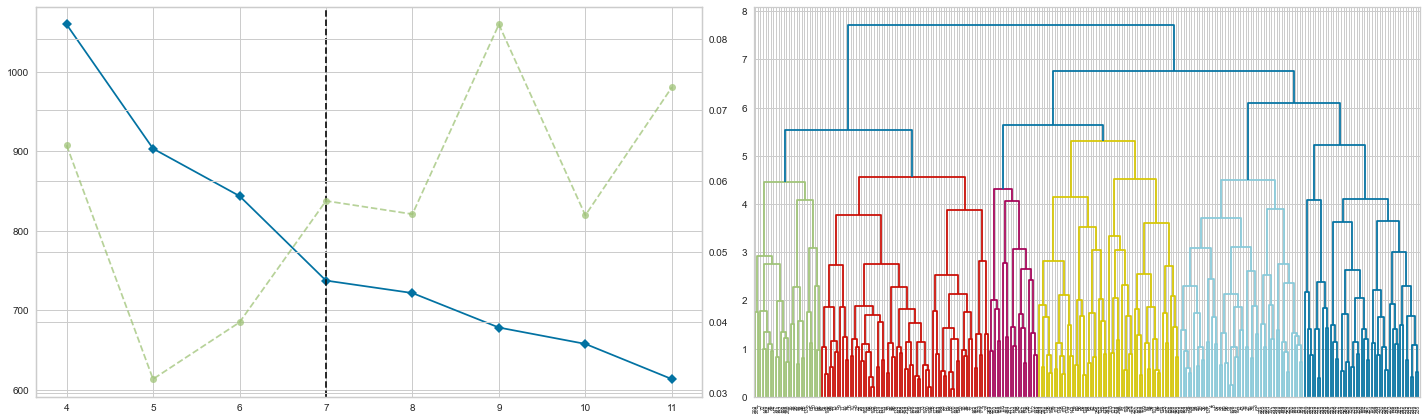

In [83]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df4, 7, 25, 2)

In [85]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df4, X, y, elbow_best_value, 2, 25, 1, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.205813,1.475032,0.281024,0.088642,0.293738,0.182977,0.226490,0.153489
AgglomerativeClustering,0.141347,2.285898,0.529196,0.204094,0.252287,0.259931,0.194529,0.391585
DBSCAN,-0.092244,1.900342,0.368484,0.025827,0.096110,0.084696,0.074107,0.098815
OPTICS,-0.160148,1.678464,0.433653,0.028690,0.207753,0.184741,0.160191,0.218179
Spectral Clustering,0.190114,2.016152,0.502168,0.188494,0.212405,0.213582,0.163778,0.306915
Affinity Propagation,0.225748,1.227265,0.214696,0.075879,0.703501,0.315715,0.542443,0.222652


In [86]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df4, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.664015,0.432996,0.530343,0.533282,0.408928,0.766320
Gaussian Mixture,0.655060,0.419776,0.505357,0.508004,0.389661,0.729582


## Hyperparameter Selection

### Mini Batch KMeans

In [87]:
# Checking best combination of hyperparameters

best_combination = [[5,25],[6,50],[7,25],[8,15],[9,15]]

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 25] combination is 1.3851845943944525
Average of all scores for [6, 50] combination is 1.6585417697396758
Average of all scores for [7, 25] combination is 1.2263615269951917
Average of all scores for [8, 15] combination is 1.5450622058378478
Average of all scores for [9, 15] combination is 1.5300254194387777


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 6, batch size = 50 

### Agglomerative Clustering

In [88]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i) 
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 1.83162360740682
Average of all scores for 3 clusters is 1.6715323476511625
Average of all scores for 4 clusters is 1.8287802586961523
Average of all scores for 5 clusters is 2.0772985577294345
Average of all scores for 6 clusters is 1.9370551394589288
Average of all scores for 7 clusters is 2.1236972380366965
Average of all scores for 8 clusters is 2.1370851343639408


The best value of number of clusters in Agglomerative Clustering is 8, which gave the highest average metric score.

### DBScan

In [89]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[3,3],[3,5],[5,7]]

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.7, 1] combination is 2.9991629701761227
Average of all scores for [1, 2] combination is 1.2060549364911224
Average of all scores for [3, 3] combination is 1.5341757290145492
Average of all scores for [3, 5] combination is 1.5341757290145492
Average of all scores for [5, 7] combination is 1.5341757290145492


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 0.7, minimum number of samples = 1 

### OPTICS

In [90]:
# Checking best value of minimum number of samples

best_combination = [3,4,5,6,7,8]

for i in best_combination:
    model = OPTICS(min_samples=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 3 samples is 1.4463646625468778
Average of all scores for 4 samples is 1.314187405739579
Average of all scores for 5 samples is 1.2332074130884525
Average of all scores for 6 samples is 0.840102315575896
Average of all scores for 7 samples is 0.8980866397481009
Average of all scores for 8 samples is 0.7773613948552597


The best value of minimum number of samples in OPTICS is 3, which gave the highest average metric score.

### Affinity Propagation 

In [91]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 1.9476904555236172
Average of all scores for [0.6, 300] combination is 2.0592076198050226
Average of all scores for [0.7, 400] combination is 2.0748867691934567
Average of all scores for [0.8, 200] combination is 2.0748867691934567
Average of all scores for [0.9, 500] combination is 2.1281363581020756


The best combinations of hyperparameters in Affinity Propagation which gave the highest average metric scores:

damping value = 0.9, maximum iterations = 500

### Spectral Clustering 

In [92]:
# Checking best combination of hyperparameters

best_combination = [[5,'discretize'],[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 'discretize'] combination is 1.8610657613892514
Average of all scores for [6, 'discretize'] combination is 1.6065372861360716
Average of all scores for [7, 'kmeans'] combination is 0.8858514017489812
Average of all scores for [8, 'kmeans'] combination is 1.6306019870576773
Average of all scores for [9, 'discretize'] combination is 1.6719344263387876


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 5, assign labels = 'discretize'

### Bayesian Gaussian Mixture

In [93]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 3.33588443924623
Average of all scores for [3, 'tied'] combination is 3.19944672446786
Average of all scores for [4, 'diag'] combination is 3.1916745544032734
Average of all scores for [5, 'spherical'] combination is 0.9708397115478299
Average of all scores for [6, 'full'] combination is 2.0046841631995003
Average of all scores for [7, 'spherical'] combination is 1.2085503114980387
Average of all scores for [8, 'diag'] combination is 1.8560704213529702


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 2, covariance type = 'full'

### Gaussian Mixture Model

In [94]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 3.207439775416007
Average of all scores for [3, 'tied'] combination is 3.19944672446786
Average of all scores for [4, 'diag'] combination is 2.4302730469560654
Average of all scores for [5, 'spherical'] combination is 1.642186251096291
Average of all scores for [6, 'full'] combination is 1.8196655938258732
Average of all scores for [7, 'spherical'] combination is 1.8459036351439295
Average of all scores for [8, 'diag'] combination is 1.3792064703545044


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 2, covariance type = 'full'

#### Analysis:

1) It is observed that the GMM outperforms Mini Batch KMeans with highest average score, which shows that the GMM is better at modeling the data according to the chosen performance metrics. This could be because the GMM is more flexible and able to capture more complex patterns in the data.

2) It is observed that the GMM outperforms Agglomerative Clustering with highest average score, it suggests that the GMM is able to more accurately and effectively cluster the data into distinct groups. This may be due to the fact that the GMM is able to account for the uncertainty in the data, whereas the Agglomerative clustering approach may be more rigid in its grouping of the data.

3) It is observed that the GMM outperforms DBScan with highest average score, which shows that that the GMM is better at clustering the data and correctly identifying the underlying structure of the data. This could be due to the fact that the GMM uses probabilistic clustering, which allows it to account for uncertainty and potential overlap between clusters. In contrast, the DBScan model uses a density-based approach and may be more sensitive to noise or outliers in the data. 

4) It is observed that the GMM outperforms OPTICS with highest average score, which shows that GMM is more effective at accurately clustering the data. This could be due to the GMM's ability to handle multimodal data and its flexibility in modeling the underlying distribution of the data.

5) It is observed that the GMM outperforms Affinity Propagation with highest average score, which shows that the GMM is a better fit for the data and is able to more accurately predict or classify the data. This could be due to the GMM's ability to model data using a continuous distribution, as opposed to the discrete clustering method used by Affinity propagation.

6) It is observed that the GMM outperforms Spectral Clustering with highest average score, which shows that the GMM is a better fit for the given data and produces more accurate or effective clustering results. This may be due to the GMM's ability to handle mixed data types and account for uncertainty in the data, or because it is more robust to noise or outliers in the data.

7) It is observed that the Bayesian GMM slightly outperforms GMM with higher average score (and very close to it), which shows that both models are performing similarly in terms of their ability to accurately predict or classify data. This may indicate that either model could be a suitable choice for the particular task at hand.

### Parameter changes:

#### (1) Based on number of components

In [95]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))

Average of all scores for 2 components is 3.207439775416007
Average of all scores for 3 components is 3.182305199375643
Average of all scores for 4 components is 2.5280192734995226
Average of all scores for 5 components is 1.74957358715293
Average of all scores for 6 components is 1.8196655938258732
Average of all scores for 7 components is 1.874400902429423


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 2. This shows that the model is able to accurately classify the data using fewer components or clusters. This may indicate that the  model is able to effectively capture the underlying structure of the data using fewer components.

#### (2) Based on covariance type

In [96]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))

Average of all scores for full covariance type is 3.207439775416007
Average of all scores for tied covariance type is 3.102746842587514
Average of all scores for diag covariance type is 3.4067420695293267
Average of all scores for spherical covariance type is 2.1137790644590844


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is 'diag'. This suggests that the data may be more effectively modeled with a diagonal covariance matrix rather than a full or spherical covariance matrix. This may indicate that the data has some degree of independence between the different features, as the diagonal covariance matrix assumes that the features are uncorrelated.

#### (3) Based on regularization of covariance

In [97]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-6, 0.5, 1.5, 3, 5]

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))

Average of all scores for regularized covariance of 1e-06 is 3.207439775416007
Average of all scores for regularized covariance of 0.5 is 1.1579325938757576
Average of all scores for regularized covariance of 1.5 is 2.282586548685729
Average of all scores for regularized covariance of 3 is 2.1871696345970753
Average of all scores for regularized covariance of 5 is 1.5341757290145492


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 1e-6. This suggests that the model is performing better when the regularization of the covariance matrices is set to a small value. This could indicate that the model is able to better fit the data when the regularization is set to a lower value, possibly because it is able to more accurately capture the underlying relationships in the data.

## Dataset 05: Dishonest Internet Users

This dataset was used to test an architecture based on a trust model capable to cope with the evaluation of the trustworthiness of users interacting in pervasive environments. In pervasive computing, the interacting users are not able to obtain information about the trustworthiness of each other. Thus, unfair users can act maliciously towards others. The data contains 321 rows and 5 columns.

In [98]:
# Loading the dataset

df5 = pd.read_csv('Classification\Dishonest Internet users dataset.txt', sep = ' ')
df5.head()

,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy
0,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy
1,CT_range_1,CU_range_4,LT_range_4,sport,trustworthy
2,CT_range_2,CU_range_1,LT_range_4,sport,trustworthy
3,CT_range_3,CU_range_1,LT_range_4,sport,trustworthy
4,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy


In [99]:
# Assigning column names

colnames = ['Counting Trust', 'Counting Untrust', 'Last Time', 'Context', 'Score']
df5.columns = colnames
df5.head()

,Counting Trust,Counting Untrust,Last Time,Context,Score
0,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy
1,CT_range_1,CU_range_4,LT_range_4,sport,trustworthy
2,CT_range_2,CU_range_1,LT_range_4,sport,trustworthy
3,CT_range_3,CU_range_1,LT_range_4,sport,trustworthy
4,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy


In [100]:
# Data shape

df5.shape

(321, 5)

In [101]:
df5.isna().sum().sum()

0

In [102]:
# Converting string columns to integer

for i in df5.select_dtypes(include=[object]).columns:
    df5[i] = pd.factorize(df5[i])[0] + 1

# Normalizing the data

ss=StandardScaler()
for i in df5.columns:
    df5[i] = ss.fit_transform(df5[[i]])

# Splitting into X and y columns

X = df5.drop(columns = ['Score'])
y = df5['Score']

For MiniBatchKMeans, the ideal number of clusters are  7
Based on dendrogram, the ideal number of clusters are  3


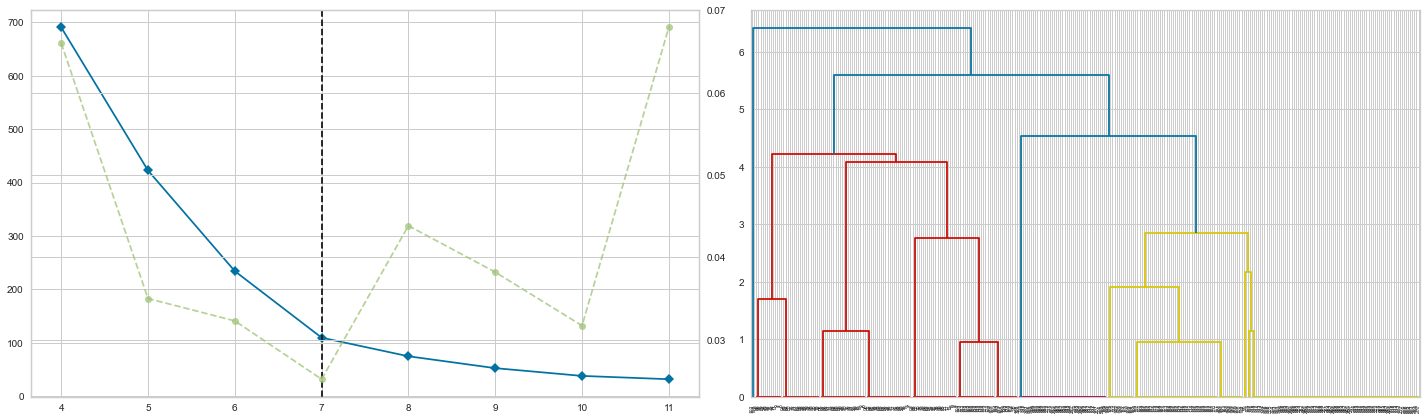

In [103]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df5, 7, 50, 3)

In [104]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df5, X, y, elbow_best_value, 3, 50, 3, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.831913,0.398188,0.510939,0.224394,0.487416,0.396625,0.798951,0.263789
AgglomerativeClustering,0.495101,1.065362,0.439478,-0.005092,0.003507,0.004129,0.005749,0.003222
DBSCAN,0.454870,0.416224,0.761209,0.000000,0.000000,0.000000,0.000000,1.000000
OPTICS,0.982775,0.040885,0.460842,0.184466,0.588625,0.405551,0.964847,0.256731
Spectral Clustering,0.414071,0.582323,0.638370,-0.076630,0.053225,0.105429,0.087244,0.133191
Affinity Propagation,0.982775,0.040885,0.460842,0.184466,0.588625,0.405551,0.964847,0.256731


In [105]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df5, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.538162,-0.003143,0.000041,0.000063,0.000067,0.00006
Gaussian Mixture,0.538162,-0.003143,0.000041,0.000063,0.000067,0.00006


## Hyperparameter Selection

### Mini Batch KMeans

In [106]:
# Checking best combination of hyperparameters

best_combination = [[5,25],[6,50],[7,25],[8,15],[8,50]]

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 25] combination is 1.5258438156053302
Average of all scores for [6, 50] combination is 1.5683562664836879
Average of all scores for [7, 25] combination is 2.1808277463071057
Average of all scores for [8, 15] combination is 3.00418029511709
Average of all scores for [8, 50] combination is 2.5789047932952838


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 8, batch size = 15 

### Agglomerative Clustering

In [107]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 0.5612683589541652
Average of all scores for 3 clusters is 0.4509931579876162
Average of all scores for 4 clusters is 0.7313973418107845
Average of all scores for 5 clusters is 1.9817602557734388
Average of all scores for 6 clusters is 2.100909908879289
Average of all scores for 7 clusters is 2.135138617255085
Average of all scores for 8 clusters is 2.46122606996671


The best value of number of clusters in Agglomerative Clustering is 8, which gave the highest average metric score.

### DBScan

In [108]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[2,4],[3,5],[5,7]]

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.7, 1] combination is 2.9212830860183487
Average of all scores for [1, 2] combination is 2.4333246398092707
Average of all scores for [2, 4] combination is 2.1013197294081496
Average of all scores for [3, 5] combination is 1.7612090726840086
Average of all scores for [5, 7] combination is 1.7612090726840086


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 0.7, minimum number of samples = 1 

### OPTICS

In [109]:
# Checking best value of minimum number of samples

best_combination = [1,2,3,4,5,6]

for i in best_combination:
    model = OPTICS(min_samples=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 1 samples is 1.7612090726840086
Average of all scores for 2 samples is 2.9212830860183487
Average of all scores for 3 samples is 2.8610623019163985
Average of all scores for 4 samples is 2.8610623019163985
Average of all scores for 5 samples is 2.8610623019163985
Average of all scores for 6 samples is 2.8610623019163985


The best value of minimum number of samples in OPTICS is 2, which gave the highest average metric score.

### Affinity Propagation

In [110]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 1.7612090726840086
Average of all scores for [0.6, 300] combination is 1.7612090726840086
Average of all scores for [0.7, 400] combination is 1.7612090726840086
Average of all scores for [0.8, 200] combination is 2.861062301916399
Average of all scores for [0.9, 500] combination is 0.541418662235664


The best combinations of hyperparameters in Affinity Propagation which gave the highest average metric scores:

damping value = 0.8, maximum iterations = 200

### Spectral Clustering

In [111]:
# Checking best combination of hyperparameters

best_combination = [[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[5,'discretize'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [6, 'discretize'] combination is 1.6242055489684768
Average of all scores for [7, 'kmeans'] combination is 2.1808277463071057
Average of all scores for [8, 'kmeans'] combination is 2.1746720957497248
Average of all scores for [5, 'discretize'] combination is 1.5258438156053302
Average of all scores for [9, 'discretize'] combination is 2.537967565796073


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 9, assign labels = 'discretize'

### Bayesian Gaussian Mixture

In [112]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.535249967229188
Average of all scores for [3, 'tied'] combination is 1.0640821317346902
Average of all scores for [4, 'diag'] combination is 0.7313973418107845
Average of all scores for [5, 'spherical'] combination is 1.970048936974462
Average of all scores for [6, 'full'] combination is 2.100909908879289
Average of all scores for [7, 'spherical'] combination is 2.1164024859589725
Average of all scores for [8, 'diag'] combination is 3.105951503096375


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 8, covariance type = 'diag'

### Gaussian Mixture Model

In [113]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.535249967229188
Average of all scores for [3, 'tied'] combination is 0.4509931579876162
Average of all scores for [4, 'diag'] combination is 0.8649034404681017
Average of all scores for [5, 'spherical'] combination is 1.970048936974462
Average of all scores for [6, 'full'] combination is 2.100909908879289
Average of all scores for [7, 'spherical'] combination is 2.093351627619255
Average of all scores for [8, 'diag'] combination is 2.7049284889260345


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 8, covariance type = 'diag'

#### Analysis:

1) It is observed that the Mini Batch KMeans outperforms GMM with highest average score, which shows that the Mini batch kmeans algorithm is better at accurately clustering and identifying patterns in the data. This could be due to the inherent structure of the data, the number of clusters, or the parameters used in the algorithms.

2) It is observed that the GMM outperforms Agglomerative Clustering with highest average score, it suggests that the GMM is able to more accurately and effectively cluster the data into distinct groups. This may be due to the fact that the GMM is able to account for the uncertainty in the data, whereas the Agglomerative clustering approach may be more rigid in its grouping of the data.

3) It is observed that the DBScan outperforms GMM with highest average score, which shows that DBScan is more accurately identifying clusters or has a lower error rate. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

4) It is observed that the OPTICS outperforms GMM with highest average score, which shows that OPTICS is more effective at clustering the data and finding meaningful patterns within it. This could be due to the fact that OPTICS is able to handle more complex and non-linear data structures, whereas GMM are limited to more simple, linear patterns.

5) It is observed that the Affinity Propagation outperforms GMM with highest average score, which shows that Affinity propagation is a better model for the data at hand. This could be because Affinity propagation is able to more accurately cluster the data, or because it is able to more accurately predict the labels of the data points.

6) It is observed that the GMM outperforms Spectral Clustering with highest average score, which shows that the GMM is a better fit for the given data and produces more accurate or effective clustering results. This may be due to the GMM's ability to handle mixed data types and account for uncertainty in the data, or because it is more robust to noise or outliers in the data.

7) It is observed that the Bayesian GMM outperforms GMM with highest average score, which shows that the Bayesian version may be slightly more effective in accurately identifying patterns and classifying data points within the dataset. This could be due to the Bayesian model's ability to incorporate prior knowledge and incorporate uncertainties in its predictions, which may lead to more accurate and robust results.

### Parameter changes:

#### (1) Based on number of components

In [114]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))

Average of all scores for 2 components is 0.535249967229188
Average of all scores for 3 components is 0.45573427767144814
Average of all scores for 4 components is 0.7357045291282702
Average of all scores for 5 components is 1.5251761604327645
Average of all scores for 6 components is 2.100909908879289
Average of all scores for 7 components is 2.7811631152525167


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 7. This suggests that the data may be best represented by a mixture of 7 different Gaussian distributions. This may indicate that the data has multiple underlying patterns or clusters, rather than a single homogenous group.

#### (2) Based on covariance type

In [115]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))

Average of all scores for full covariance type is 0.535249967229188
Average of all scores for tied covariance type is 0.6575865188240648
Average of all scores for diag covariance type is 0.9164479492262471
Average of all scores for spherical covariance type is 0.5946152792822742


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is 'diag'. This suggests that the data may be more effectively modeled with a diagonal covariance matrix rather than a full or spherical covariance matrix. This may indicate that the data has some degree of independence between the different features, as the diagonal covariance matrix assumes that the features are uncorrelated.

#### (3) Based on regularization of covariance

In [116]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-6, 0.5, 1.5, 3, 5]

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))

Average of all scores for regularized covariance of 1e-06 is 0.535249967229188
Average of all scores for regularized covariance of 0.5 is 0.5874869777202333
Average of all scores for regularized covariance of 1.5 is 0.7363426413007261
Average of all scores for regularized covariance of 3 is 0.9164479492262471
Average of all scores for regularized covariance of 5 is 1.7612090726840086


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 5. This may indicate that there is some level of complexity in the data that requires a higher level of regularization in order to accurately model the data. It may also suggest that the model is less prone to overfitting when the regularization parameter is set to this value.

## Dataset 06: Travel Reviews Dataset

This dataset contains reviews on destinations in 10 categories mentioned across East Asia. Each traveler rating is mapped as Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0) and average rating is used against each category per user. The data contains 980 rows and 11 columns.

In [176]:
# Loading the dataset

df6 = pd.read_csv('Classification/tripadvisor_review.csv')
df6.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [177]:
# Data shape

df6.shape

(980, 11)

In [178]:
# Checking null values

df6.isna().sum().sum()

0

In [179]:
# Converting string columns to integer

for i in df6.select_dtypes(include=[object]).columns:
    df6[i] = pd.factorize(df6[i])[0] + 1

# Normalizing the data 

ss=StandardScaler()
for i in df6.columns:
    df6[i] = ss.fit_transform(df6[[i]])

# Splitting into X and y columns

X = df6.drop(columns = ['Category 10'])
y = df6['Category 10']

For MiniBatchKMeans, the ideal number of clusters are  7
Based on dendrogram, the ideal number of clusters are  2


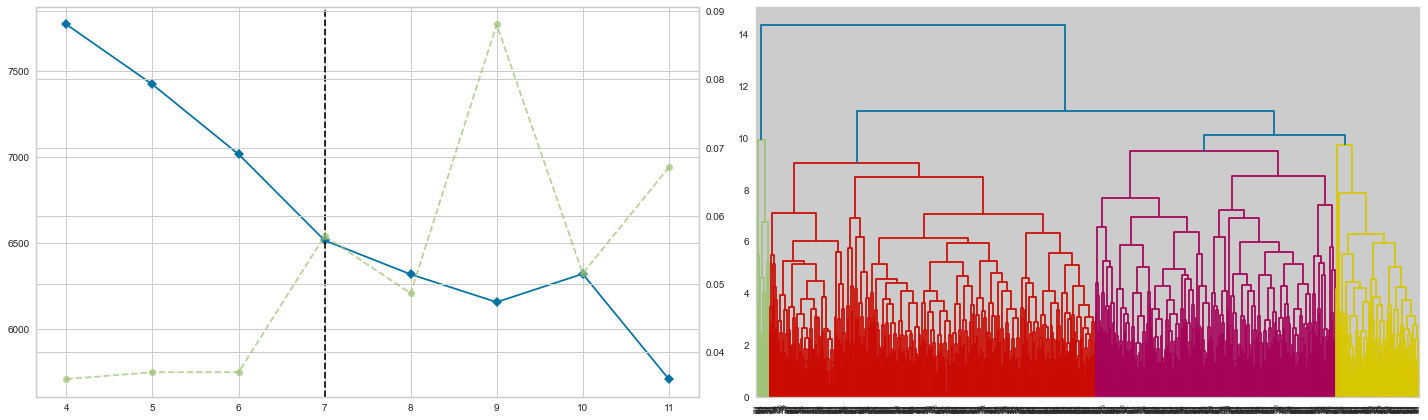

In [121]:
# Calling function to create elbow curve and dendrogram

elbow_curve_and_dendrogram(df6, 7, 100, 2)

In [122]:
# Calling function to create a dataframe of metric scores for six clustering algorithms

evaluation_matrix(df6, X, y, elbow_best_value, 2, 100, 3, 5, 2, 'discretize', 0.8, 500, 'euclidean')

,silhouette_score,davies_bouldin_score,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
MiniBatchKMeans,0.099167,2.086940,0.090583,0.017145,0.403577,0.144691,0.107734,0.220245
AgglomerativeClustering,0.182018,1.975458,0.143031,0.010060,0.211497,0.096528,0.056459,0.332521
DBSCAN,0.425830,1.997342,0.157748,-0.000193,0.019701,0.010301,0.005259,0.248877
OPTICS,-0.283597,1.591408,0.146623,-0.000613,0.158888,0.075748,0.042415,0.353777
Spectral Clustering,0.431849,0.980920,0.155472,-0.000796,0.026983,0.014062,0.007203,0.294528
Affinity Propagation,0.103215,1.580660,0.042682,0.022238,1.498444,0.378400,0.400006,0.359009


In [123]:
# Calling function to create a dataframe of metric scores for GMM and Bayesian GMM

bayesian_and_gaussian(df6, X, y, 2, 'full', 1e-6)

,fowlkes_mallows_score,adjusted_rand_score,mutual_info_score,v_measure_score,homogeneity_score,completeness_score
Bayesian Gaussian Mixture,0.141725,-0.000416,0.054283,0.026404,0.014491,0.148435
Gaussian Mixture,0.140241,-0.000146,0.055592,0.026836,0.014840,0.139993


## Hyperparameter Selection

### Mini Batch KMeans

In [124]:
# Checking best combination of hyperparameters

best_combination = [[5,50],[6,100],[7,50],[8,75],[8,100]]

for i in best_combination:
    model = MiniBatchKMeans(n_clusters=i[0], random_state=0, batch_size=i[1])
    labels2 = model.fit(X).predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [5, 50] combination is 0.9251387818744169
Average of all scores for [6, 100] combination is 0.9824081394553874
Average of all scores for [7, 50] combination is 0.9844710547666333
Average of all scores for [8, 75] combination is 1.049305991010344
Average of all scores for [8, 100] combination is 0.9821136279176623


The best combination of hyperparameters in Mini Batch KMeans which gave the highest average metric score includes:

number of clusters = 8, batch size = 75 

### Agglomerative Clustering

In [125]:
# Checking best value of cluster

best_combination = [2,3,4,5,6,7,8]

for i in best_combination:
    model = AgglomerativeClustering(n_clusters=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each cluster value
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each cluster

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' clusters is ' + str(mean_scores))

Average of all scores for 2 clusters is 0.8500963952696411
Average of all scores for 3 clusters is 0.860239991607578
Average of all scores for 4 clusters is 0.856923227111015
Average of all scores for 5 clusters is 0.9336879315032565
Average of all scores for 6 clusters is 0.9704852093625982
Average of all scores for 7 clusters is 1.0428021464119
Average of all scores for 8 clusters is 1.0613152640678891


The best value of number of clusters in Agglomerative Clustering is 8, which gave the highest average metric score.

### DBScan

In [126]:
# Checking best combination of hyperparameters

best_combination = [[0.7,1],[1,2],[2,4],[3,5],[5,7]]

for i in best_combination:
    model = DBSCAN(eps=i[0], min_samples=i[1])
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.7, 1] combination is 5.992941421979577
Average of all scores for [1, 2] combination is 1.711762600359576
Average of all scores for [2, 4] combination is 0.5393896429830515
Average of all scores for [3, 5] combination is 0.44169276577141225
Average of all scores for [5, 7] combination is 1.1607696047602378


The best combination of hyperparameters in DBScan which gave the highest average metric score includes:

maximum distance between two samples (eps) = 0.7, minimum number of samples = 1 

### OPTICS

In [127]:
# Checking best value of minimum number of samples

best_combination = [1,2,3,4,5,6]

for i in best_combination:
    model = OPTICS(min_samples=i)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of minimum samples
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of minimum samples
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' samples is ' + str(mean_scores))

Average of all scores for 1 samples is 1.1607696047602378
Average of all scores for 2 samples is 2.816600629748442
Average of all scores for 3 samples is 1.5710314311470048
Average of all scores for 4 samples is 0.944442177410195
Average of all scores for 5 samples is 0.776837867299771
Average of all scores for 6 samples is 0.731203819523641


The best value of minimum number of samples in OPTICS is 2, which gave the highest average metric score.

### Affinity Propagation

In [128]:
# Checking best combination of hyperparameters

best_combination = [[0.5,200],[0.6,300],[0.7,400],[0.8,200],[0.9,500]]

for i in best_combination:
    model = AffinityPropagation(damping=i[0], max_iter=i[1], affinity="euclidean", random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [0.5, 200] combination is 2.7145976496905635
Average of all scores for [0.6, 300] combination is 2.6873760559926216
Average of all scores for [0.7, 400] combination is 2.668565948062697
Average of all scores for [0.8, 200] combination is 2.7007780973454967
Average of all scores for [0.9, 500] combination is 2.7007780973454967


The best combinations of hyperparameters in Affinity Propagation which gave the highest average metric scores:

damping value = 0.5, maximum iterations = 200

### Spectral Clustering

In [129]:
# Checking best combination of hyperparameters

best_combination = [[6,'discretize'],[7,'kmeans'],[8,'kmeans'],[5,'discretize'],[9,'discretize']]

for i in best_combination:
    model = SpectralClustering(n_clusters=i[0], assign_labels=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [6, 'discretize'] combination is 0.6252352629560597
Average of all scores for [7, 'kmeans'] combination is 0.6259492312972383
Average of all scores for [8, 'kmeans'] combination is 0.6126555733357177
Average of all scores for [5, 'discretize'] combination is 0.6022010360886407
Average of all scores for [9, 'discretize'] combination is 0.6405427700552899


The best combination of hyperparameters in Spectral Clustering that gave the highest average metric score includes:

number of clusters = 9, assign labels = 'discretize'

### Bayesian Gaussian Mixture

In [130]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = BayesianGaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.3849224719476438
Average of all scores for [3, 'tied'] combination is 0.6385415307080297
Average of all scores for [4, 'diag'] combination is 1.4309225337557945
Average of all scores for [5, 'spherical'] combination is 0.9725630857175143
Average of all scores for [6, 'full'] combination is 1.397710215871594
Average of all scores for [7, 'spherical'] combination is 1.0228116114258772
Average of all scores for [8, 'diag'] combination is 1.4556176812319068


The best combination of hyperparameters in Bayesian Gaussian Mixture that gave the highest average metric score includes:

number of components = 8, covariance type = 'diag'

### Gaussian Mixture Model

In [131]:
# Checking best combination of hyperparameters

best_combination = [[2,'full'],[3,'tied'],[4,'diag'],[5,'spherical'],[6,'full'],[7, 'spherical'],[8, 'diag']]

for i in best_combination:
    model = GaussianMixture(n_components=i[0], covariance_type=i[1], random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each combination of hyperparameters
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each combination
    
    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' combination is ' + str(mean_scores))

Average of all scores for [2, 'full'] combination is 0.3773558724049121
Average of all scores for [3, 'tied'] combination is 0.6054982923250543
Average of all scores for [4, 'diag'] combination is 1.4335040038138944
Average of all scores for [5, 'spherical'] combination is 0.9886588673369368
Average of all scores for [6, 'full'] combination is 1.4176692523608636
Average of all scores for [7, 'spherical'] combination is 1.0224498458292681
Average of all scores for [8, 'diag'] combination is 1.451627030258537


The best combination of hyperparameters in Gaussian Mixture Model that gave the highest average metric score includes:

number of components = 8, covariance type = 'diag'

#### Analysis:

1) It is observed that the GMM outperforms Mini Batch KMeans with highest average score, which shows that the GMM is better at modeling the data according to the chosen performance metrics. This could be because the GMM is more flexible and able to capture more complex patterns in the data.

2) It is observed that the GMM outperforms Agglomerative Clustering with highest average score, it suggests that the GMM is able to more accurately and effectively cluster the data into distinct groups. This may be due to the fact that the GMM is able to account for the uncertainty in the data, whereas the Agglomerative clustering approach may be more rigid in its grouping of the data.

3) It is observed that the DBScan outperforms GMM with highest average score, which shows that DBScan is more accurately identifying clusters or has a lower error rate. This could be due to the nature of the data, the chosen distance metric, or the number of clusters being considered.

4) It is observed that the OPTICS outperforms GMM with highest average score, which shows that OPTICS is more effective at clustering the data and finding meaningful patterns within it. This could be due to the fact that OPTICS is able to handle more complex and non-linear data structures, whereas GMM are limited to more simple, linear patterns.

5) It is observed that the Affinity Propagation outperforms GMM with highest average score, which shows that Affinity propagation is a better model for the data at hand. This could be because Affinity propagation is able to more accurately cluster the data, or because it is able to more accurately predict the labels of the data points.

6) It is observed that the GMM outperforms Spectral Clustering with highest average score, which shows that the GMM is a better fit for the given data and produces more accurate or effective clustering results. This may be due to the GMM's ability to handle mixed data types and account for uncertainty in the data, or because it is more robust to noise or outliers in the data.

7) It is observed that the Bayesian GMM slighty outperforms GMM with higher average score (and very close to it), which shows that both models are performing similarly in terms of their ability to accurately predict or classify data. This may indicate that either model could be a suitable choice for the particular task at hand.

### Parameter changes:

#### (1) Based on number of components

In [180]:
# Changing number of components to obtain the best value

number_of_components = [2,3,4,5,6,7]

mean_score_list = []

for i in number_of_components:
    model = GaussianMixture(n_components=i, covariance_type='full', reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of number of components

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of number of components

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' components is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for 2 components is 0.3773558724049121
Average of all scores for 3 components is 0.7516366627446296
Average of all scores for 4 components is 0.9680152359535268
Average of all scores for 5 components is 1.340197798569889
Average of all scores for 6 components is 1.4176692523608636
Average of all scores for 7 components is 1.4513433912126934


Upon increasing and decreasing the number of components parameter in GMM, it is observed that the best score is obtained when the number of components are 7. This suggests that the data may be best represented by a mixture of 7 different Gaussian distributions. This may indicate that the data has multiple underlying patterns or clusters, rather than a single homogenous group.

#### Plotting n_component parameter's performance

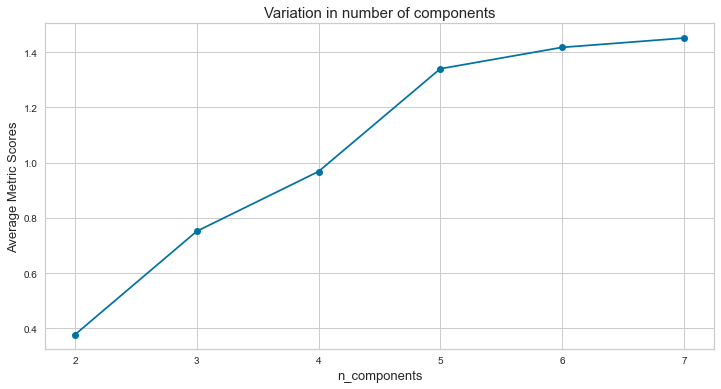

In [183]:
list_of_components = [number_of_components[0], number_of_components[1], number_of_components[2], number_of_components[3], 
                      number_of_components[4], number_of_components[5]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 'o', label = [list_of_components])
plt.xlabel('n_components', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('Variation in number of components', fontsize=15)
plt.xticks([0,1,2,3,4,5], list_of_components)
plt.show()

#### (2) Based on covariance type

In [189]:
# Changing covariance type to obtain the best value

type_of_covariance = ['full', 'tied', 'diag', 'spherical']

mean_score_list = []

for i in type_of_covariance:
    model = GaussianMixture(n_components=2, covariance_type=i, reg_covar=1e-6, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each covariance type
    
    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each covariance type

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + str(i) + ' covariance type is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for full covariance type is 0.3773558724049121
Average of all scores for tied covariance type is 0.6066992067956762
Average of all scores for diag covariance type is 0.9071135882301672
Average of all scores for spherical covariance type is 0.8186962658749639


Upon changing the type of covariance parameter in GMM, it is observed that the best score is obtained when the covariance type is 'diag'. This suggests that the data may be more effectively modeled with a diagonal covariance matrix rather than a full or spherical covariance matrix. This may indicate that the data has some degree of independence between the different features, as the diagonal covariance matrix assumes that the features are uncorrelated.

#### Plotting covariance_type parameter's performance

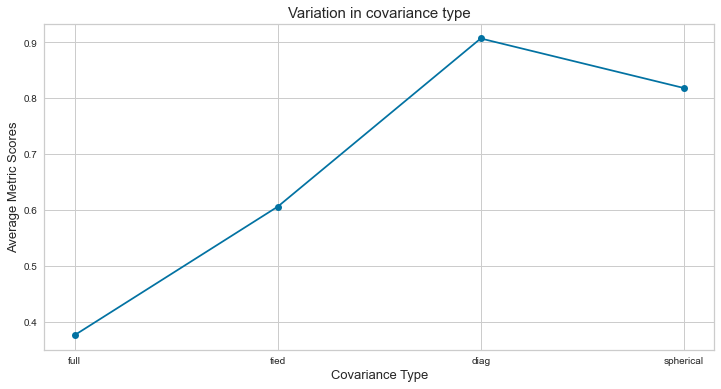

In [190]:
list_of_covariance_types = [type_of_covariance[0], type_of_covariance[1], type_of_covariance[2], type_of_covariance[3]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 'o', label = [list_of_covariance_types])
plt.xlabel('Covariance Type', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('Variation in covariance type', fontsize=15)
plt.xticks([0,1,2,3], list_of_covariance_types)
plt.show()

#### (3) Based on regularization of covariance

In [191]:
# Changing the value of regularized covariance to obtain the best value

regularization_covariance = [1e-6, 0.5, 1.5, 3, 5]

mean_score_list = []

for i in regularization_covariance:
    model = GaussianMixture(n_components=2, covariance_type='full', reg_covar=i, random_state=0)
    labels2 = model.fit(X).fit_predict(X)
    
    # Calculating extrinsic measures for each value of regularized covariance

    fowlkes_mallows = fowlkes_mallows_score(y,labels2)
    adjusted_rand = adjusted_rand_score(y,labels2)
    mutual_info = mutual_info_score(y,labels2)
    v_measure = v_measure_score(y,labels2)
    homogeneity = homogeneity_score(y,labels2)
    completeness = completeness_score(y,labels2)
    
    # Evaluating means of respective scores for each value of regularized covariance

    scores = [fowlkes_mallows + adjusted_rand + mutual_info + v_measure + homogeneity + completeness]
    mean_scores = sum(scores)/len(scores)
    print('Average of all scores for ' + 'regularized covariance of ' + str(i) + ' is ' + str(mean_scores))
    mean_score_list.append(mean_scores)

Average of all scores for regularized covariance of 1e-06 is 0.3773558724049121
Average of all scores for regularized covariance of 0.5 is 0.4313022182480828
Average of all scores for regularized covariance of 1.5 is 0.48415954972101566
Average of all scores for regularized covariance of 3 is 0.5006513420013152
Average of all scores for regularized covariance of 5 is 1.1607696047602378


Upon increasing and decreasing the regularized covariance in GMM, it is observed that the best score is obtained when the value is 5. This may indicate that there is some level of complexity in the data that requires a higher level of regularization in order to accurately model the data. It may also suggest that the model is less prone to overfitting when the regularization parameter is set to this value.

#### Plotting reg_covar parameter's performance

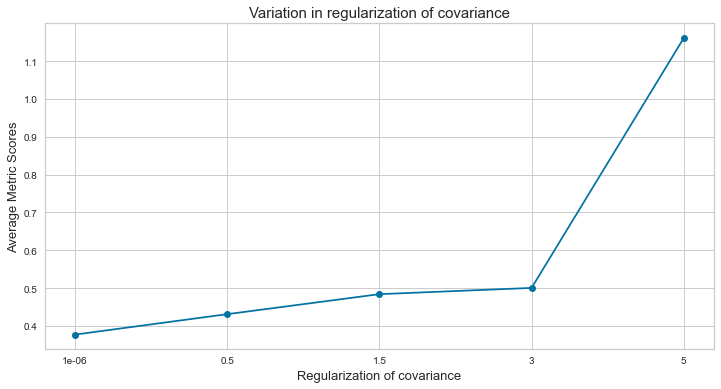

In [192]:
list_of_reg_covar = [regularization_covariance[0], regularization_covariance[1], regularization_covariance[2], 
                     regularization_covariance[3], regularization_covariance[4]]
plt.figure(figsize = (12,6))
plt.plot(mean_score_list, marker = 'o', label = [list_of_reg_covar])
plt.xlabel('Regularization of covariance', fontsize=13)
plt.ylabel('Average Metric Scores', fontsize=13)
plt.title('Variation in regularization of covariance', fontsize=15)
plt.xticks([0,1,2,3,4], list_of_reg_covar)
plt.show()